# AnyoneAI - Sprint Project 02
> Home Credit Default Risk

You've been learning a lot about Machine Learning Algorithms, now we you're gonna be asked to put it all togheter. 

You will create a complete pipeline to preprocess the data, train your model and then predict values for the [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/) Kaggle competition.


## 1. Introduction

This is a binary Classification task: we want to predict whether the person applying for a home credit will be able to repay their debt or not. Our model will have to predict a 1 indicating the client will have payment difficulties: he/she will have late payment of more than X days on at least one of the first Y installments of the loan in our sample, 0 in all other cases.

The dataset is composed of multiple files with different information about loans taken. In this project, we will work exclusively with the primary files: `application_train_aai.csv` and `application_test_aai.csv`.

We will use [Area Under the ROC Curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=es_419) as the evaluation metric, so our models will have to return the probabilities that a loan is not paid for each row.

In [1]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.validation import check_is_fitted

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src import config, data_utils, preprocessing

### Getting the data

To access the data for this project, you only need to execute the code below. This will download three files inside the `dataset` folder:

- `application_train_aai.csv`: Training dataset you must use to train and find the best hyperparameters on your model.

- `application_test_aai.csv`: Test dataset without labels. Because of the absence of labels, you can't use this dataset for your experiments. You will use the file only at the end after you choose what you think is the best model for the tasks. You will have to use that model to fill values in the `TARGET` column using the model predictions. Then submit this dataset alongside this Jupyter notebook, AnyoneAI will internally evaluate your model's accuracy in the hidden data and communicate later ;).

- `HomeCredit_columns_description.csv`: This file contains descriptions for the columns in train and test datasets.


1.1. Load the training and test datasets. Also, the auxiliary file `HomeCredit_columns_description.csv` has additional information about the features in the dataset.

**Don't change anything in this cell, just make it run correctly**

In [2]:
app_train, app_test, columns_description = data_utils.get_datasets()


if app_train.shape == (246008, 122):
    print("Success: app_train shape is correct!")
else:
    raise ValueError("Train dataset shape is incorrect, please review your code")

if isinstance(app_train, pd.DataFrame):
    print("Success: app_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if app_test.shape == (61503, 122):
    print("Success: app_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(app_test, pd.DataFrame):
    print("Success: app_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

Success: app_train shape is correct!
Success: app_train type is correct!
Success: app_test shape is correct!
Success: app_test type is correct!


### Exploratory Data Analysis

A lot of the analysis of the data can be found on publicly available Kaggle kernels or blog posts, but you need to make sure you understand the dataset's properties before starting working on it, so we'll do exploratory data analysis for the main files.

#### Dataset Basics

1.2. Print how many samples do we have in our train and test datasets.

In [3]:
### TODO Complete in this cell: shape of the dataset
print(f"Train dataset shape: {app_train.shape}")
print(f"Test dataset shape: {app_test.shape}")


Train dataset shape: (246008, 122)
Test dataset shape: (61503, 122)


1.3. List all columns in the train dataset.

In [4]:
### TODO Complete in this cell: Show all columns in the training dataset
print("Columns in the training dataset:")
print(app_train.columns.tolist())


Columns in the training dataset:
['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_B

1.4. Show the first 5 records of the training dataset, transpose the dataframe to see each record as a column and features as rows, make sure all features are visualized. Take your time to review what kind of information you can gather from this data.

For reference only, it should look like this:

|0|1|2|3|4
|---|---|---|---|---
Unnamed: 0|187399|84777|268140|270686|33785
SK_ID_CURR|317244|198357|410700|413785|139141
TARGET|0|0|0|0|0
NAME_CONTRACT_TYPE|Cash loans|Cash loans|Cash loans|Cash loans|Cash loans
...|...|...|...|...|...
AMT_REQ_CREDIT_BUREAU_DAY|0.0|0.0|0.0|0.0|0.0

In [5]:
### TODO Complete in this cell: show first 5 records in a transposed table
# Get first 5 records and transpose
app_train_head = app_train.head(5).T
print(app_train_head)


                                     0           1                2  \
SK_ID_CURR                      428247      140966           407283   
TARGET                               0           0                0   
NAME_CONTRACT_TYPE          Cash loans  Cash loans  Revolving loans   
CODE_GENDER                          F           M                F   
FLAG_OWN_CAR                         N           Y                N   
...                                ...         ...              ...   
AMT_REQ_CREDIT_BUREAU_DAY          NaN         0.0              0.0   
AMT_REQ_CREDIT_BUREAU_WEEK         NaN         0.0              0.0   
AMT_REQ_CREDIT_BUREAU_MON          NaN         0.0              0.0   
AMT_REQ_CREDIT_BUREAU_QRT          NaN         0.0              0.0   
AMT_REQ_CREDIT_BUREAU_YEAR         NaN         0.0              0.0   

                                     3           4  
SK_ID_CURR                      434300      446788  
TARGET                               0   

1.5. Show the distribution of the target variable values: print the total value count and the percentage of each value, plot this relationship.

Target variable distribution:
Count:
TARGET
0    226257
1     19751
Name: count, dtype: int64

Percentage:
TARGET
0    91.971399
1     8.028601
Name: proportion, dtype: float64


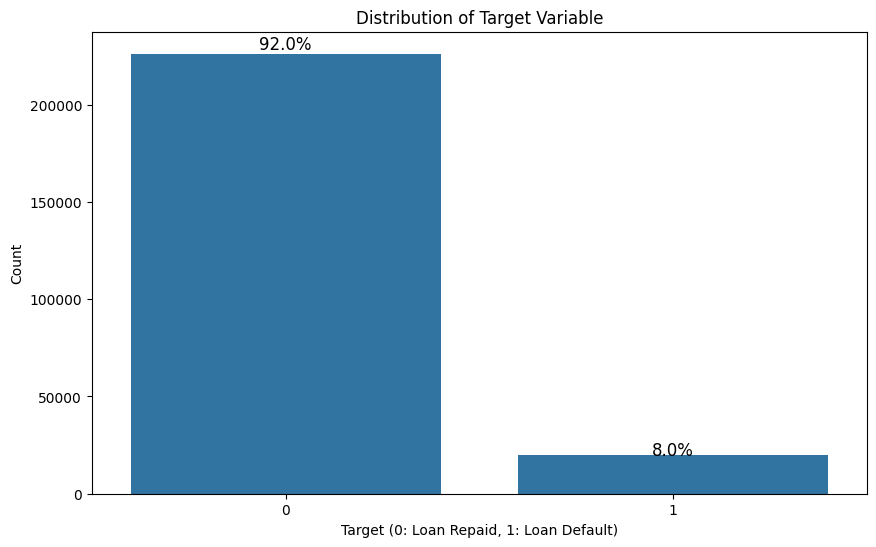

In [6]:
### TODO Complete in this cell: show distribution of target variable
# Count the values in the target variable
target_counts = app_train['TARGET'].value_counts()
target_percent = app_train['TARGET'].value_counts(normalize=True) * 100

# Print the counts and percentages
print("Target variable distribution:")
print(f"Count:\n{target_counts}")
print(f"\nPercentage:\n{target_percent}")

# Plot the distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='TARGET', data=app_train)

# Add percentage labels on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.01 * height,
            f'{height/len(app_train)*100:.1f}%', 
            ha="center", fontsize=12)

plt.title('Distribution of Target Variable')
plt.xlabel('Target (0: Loan Repaid, 1: Loan Default)')
plt.ylabel('Count')
plt.show()


1.6. Show the number of columns of each data type.

Just for giving you an idea, the output should look like this (not exactly the same numbers):

```python
float64    45
int64      32
object     10
```

In [7]:
### TODO Complete in this cell: show number of columns per data type
# Get the count of columns by data type
dtypes_count = app_train.dtypes.value_counts()
print("Number of columns by data type:")
print(dtypes_count)


Number of columns by data type:
float64    65
int64      41
object     16
Name: count, dtype: int64


1.7. For categorical variables (`object` data type), show the number of distinct values in each column (number of labels).

Just for giving you an idea, the output should look like this (not exactly the same numbers):

```python
NAME_CONTRACT_TYPE             5
CODE_GENDER                    2
FLAG_OWN_CAR                   1
FLAG_OWN_REALTY                1
...
```

In [8]:
### TODO Complete in this cell: show number of unique values per categorical column
# Get categorical columns (object type)
categorical_columns = app_train.select_dtypes(include=['object']).columns

# Get number of unique values for each categorical column
unique_values = app_train[categorical_columns].nunique().sort_values(ascending=False)

print("Number of unique values in categorical columns:")
print(unique_values)


Number of unique values in categorical columns:
ORGANIZATION_TYPE             58
OCCUPATION_TYPE               18
NAME_INCOME_TYPE               8
NAME_TYPE_SUITE                7
WALLSMATERIAL_MODE             7
WEEKDAY_APPR_PROCESS_START     7
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_EDUCATION_TYPE            5
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
CODE_GENDER                    3
FLAG_OWN_CAR                   2
NAME_CONTRACT_TYPE             2
FLAG_OWN_REALTY                2
EMERGENCYSTATE_MODE            2
dtype: int64


1.8. Analyzing missing data: show the percentage of missing data for each column ordered by percentage descending (show only the 20 columns with higher missing pct)

Just for giving you an idea, the output should look like this (not exactly the same numbers and columns names):

```python
                   Total   Percent
COMMONAREA_AVG    121000      85.2
COMMONAREA_MODE   121000      76.6
COMMONAREA_MEDI   121000      62.9
...
```

In [9]:
### TODO Complete in this cell: checking missing data
# Calculate missing values
missing_values = app_train.isnull().sum()
missing_percent = missing_values / len(app_train) * 100

# Create a DataFrame with the results
missing_df = pd.DataFrame({
    'Total': missing_values,
    'Percent': missing_percent
})

# Filter out columns with no missing values
missing_df = missing_df[missing_df['Total'] > 0]

# Sort by percentage of missing values (descending)
missing_df = missing_df.sort_values('Percent', ascending=False)

# Display only the top 20 columns with most missing values
print("Top 20 columns with missing values:")
print(missing_df.head(20))


Top 20 columns with missing values:
                           Total    Percent
COMMONAREA_MEDI           172189  69.993252
COMMONAREA_MODE           172189  69.993252
COMMONAREA_AVG            172189  69.993252
NONLIVINGAPARTMENTS_MODE  171096  69.548958
NONLIVINGAPARTMENTS_MEDI  171096  69.548958
NONLIVINGAPARTMENTS_AVG   171096  69.548958
FONDKAPREMONT_MODE        168561  68.518503
LIVINGAPARTMENTS_AVG      168494  68.491269
LIVINGAPARTMENTS_MEDI     168494  68.491269
LIVINGAPARTMENTS_MODE     168494  68.491269
FLOORSMIN_MEDI            167255  67.987626
FLOORSMIN_MODE            167255  67.987626
FLOORSMIN_AVG             167255  67.987626
YEARS_BUILD_MODE          163980  66.656369
YEARS_BUILD_MEDI          163980  66.656369
YEARS_BUILD_AVG           163980  66.656369
OWN_CAR_AGE               162503  66.055982
LANDAREA_AVG              146436  59.524893
LANDAREA_MEDI             146436  59.524893
LANDAREA_MODE             146436  59.524893


#### Analyzing distribution of variables

1.9. Show the distribution of credit amounts.

*Hint:* Take a look at `AMT_CREDIT` column.

Credit amount statistics:
count    2.460080e+05
mean     5.991707e+05
std      4.034845e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.124465e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64


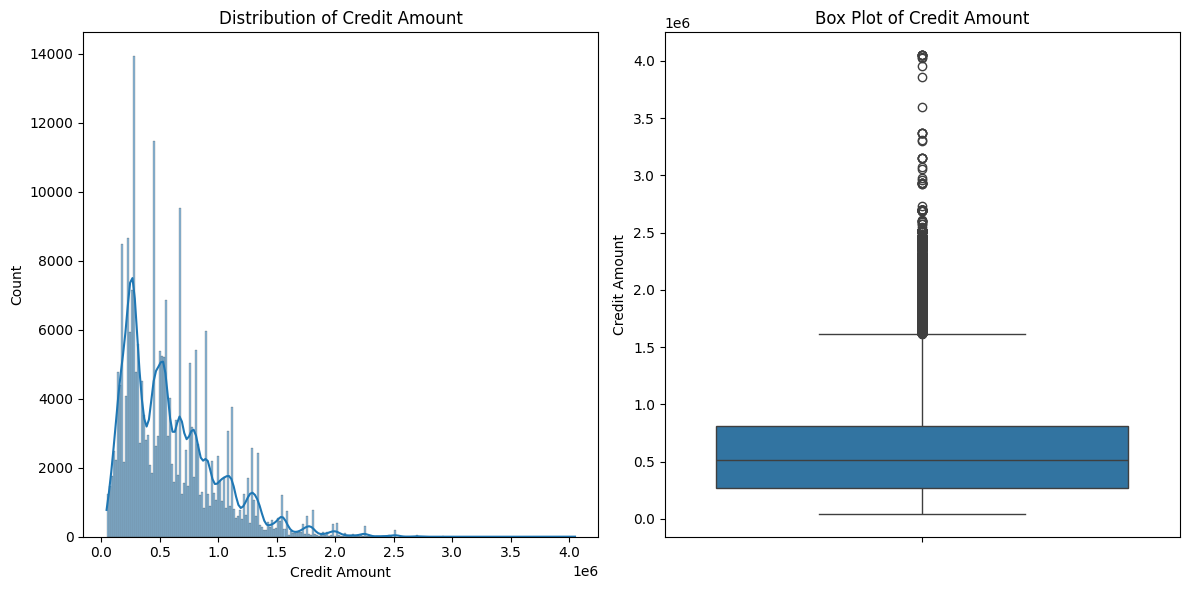

In [10]:
### TODO Complete in this cell: distribution of credit amounts
# Get basic statistics of the AMT_CREDIT column
print("Credit amount statistics:")
print(app_train['AMT_CREDIT'].describe())

# Plot the distribution of credit amounts
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(app_train['AMT_CREDIT'], kde=True)
plt.title('Distribution of Credit Amount')
plt.xlabel('Credit Amount')
plt.ylabel('Count')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(y=app_train['AMT_CREDIT'])
plt.title('Box Plot of Credit Amount')
plt.ylabel('Credit Amount')

plt.tight_layout()
plt.show()


1.10. Plot the education level of the credit applicants, show the percentages of each category. Also print the total counts for each category.

*Hint:* Take a look at `NAME_EDUCATION_TYPE` column.

Education level distribution:
Count:
NAME_EDUCATION_TYPE
Secondary / secondary special    174657
Higher education                  59990
Incomplete higher                  8248
Lower secondary                    2984
Academic degree                     129
Name: count, dtype: int64

Percentage:
NAME_EDUCATION_TYPE
Secondary / secondary special    70.996472
Higher education                 24.385386
Incomplete higher                 3.352736
Lower secondary                   1.212969
Academic degree                   0.052437
Name: proportion, dtype: float64


C:\Users\joel_\AppData\Local\Temp\ipykernel_25936\4089490916.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'{width} ({education_percent[i]:.1f}%)',


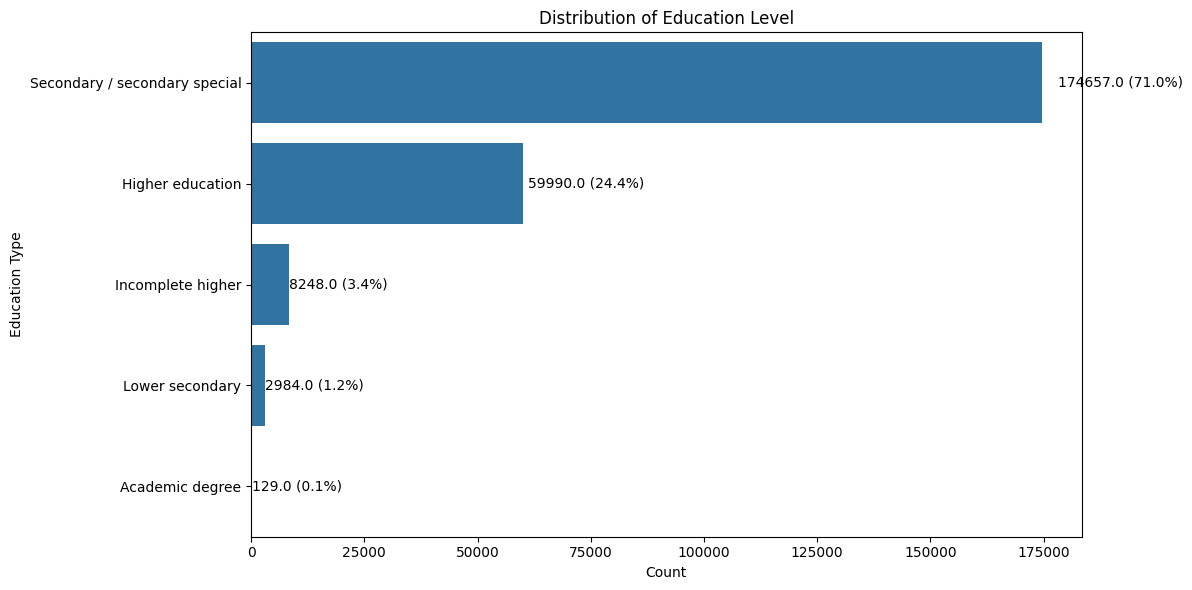

In [11]:
### TODO Complete in this cell: level of education plot
# Count the values in the education type column
education_counts = app_train['NAME_EDUCATION_TYPE'].value_counts()
education_percent = app_train['NAME_EDUCATION_TYPE'].value_counts(normalize=True) * 100

# Print the counts and percentages
print("Education level distribution:")
print(f"Count:\n{education_counts}")
print(f"\nPercentage:\n{education_percent}")

# Plot the distribution
plt.figure(figsize=(12, 6))
ax = sns.countplot(y='NAME_EDUCATION_TYPE', data=app_train, order=education_counts.index)

# Add percentage labels
for i, p in enumerate(ax.patches):
    width = p.get_width()
    plt.text(width + width * 0.02, p.get_y() + p.get_height()/2, 
             f'{width} ({education_percent[i]:.1f}%)',
             ha='left', va='center')

plt.title('Distribution of Education Level')
plt.xlabel('Count')
plt.ylabel('Education Type')
plt.tight_layout()
plt.show()


1.11. Plot the distribution of ocupation of the loan applicants.

*Hint:* Take a look at `OCCUPATION_TYPE` column.

Occupation distribution:
Count:
OCCUPATION_TYPE
Laborers                 44108
Sales staff              25770
Core staff               22041
Managers                 16992
Drivers                  14874
High skill tech staff     8981
Accountants               7915
Medicine staff            6879
Security staff            5364
Cooking staff             4771
Cleaning staff            3731
Private service staff     2140
Low-skill Laborers        1687
Waiters/barmen staff      1094
Secretaries               1043
Realty agents              625
IT staff                   443
HR staff                   431
Name: count, dtype: int64

Percentage:
OCCUPATION_TYPE
Laborers                 26.116562
Sales staff              15.258543
Core staff               13.050584
Managers                 10.061046
Drivers                   8.806968
High skill tech staff     5.317694
Accountants               4.686510
Medicine staff            4.073089
Security staff            3.176051
Cooking staff           

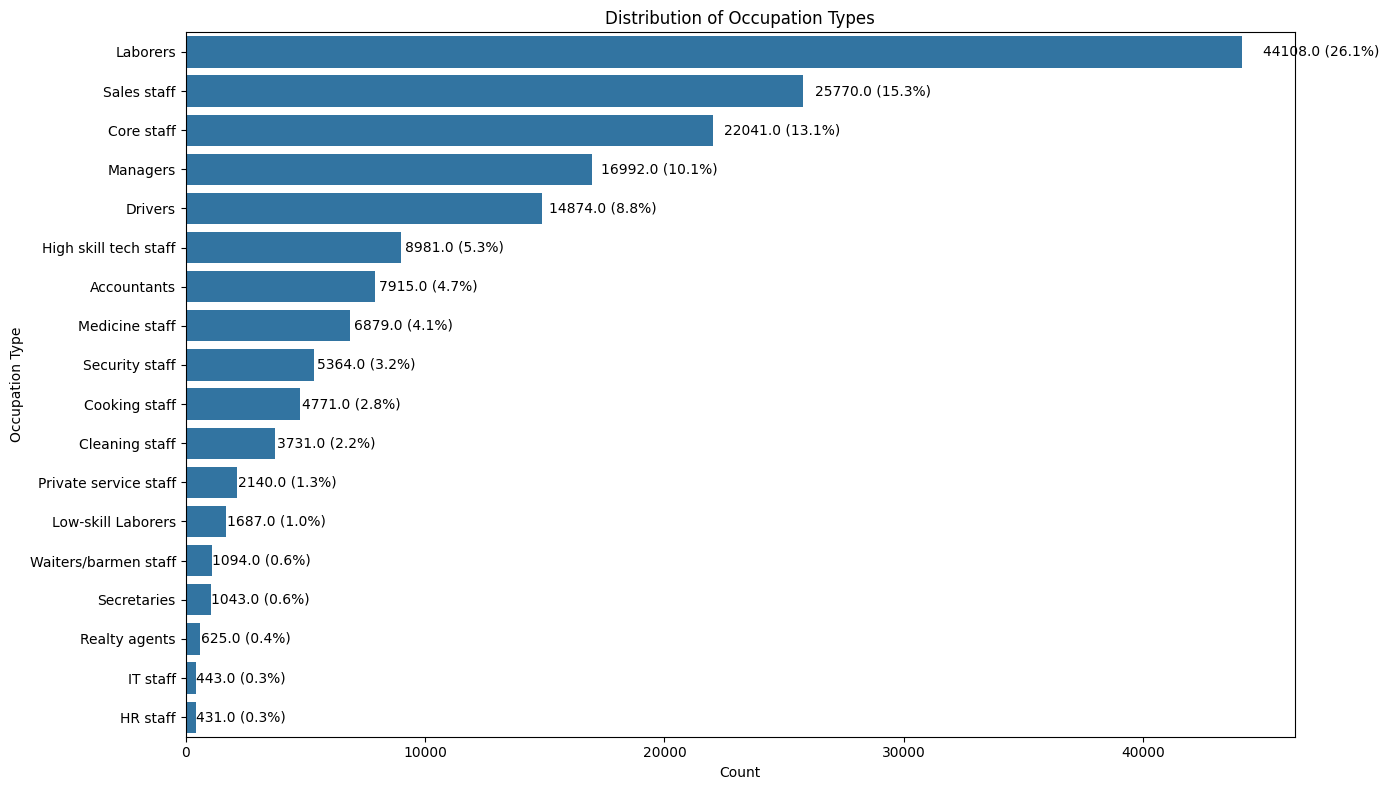

In [12]:
### TODO Complete in this cell: ocupation of applicants
# Count the values in the occupation type column
occupation_counts = app_train['OCCUPATION_TYPE'].value_counts().sort_values(ascending=False)
occupation_percent = app_train['OCCUPATION_TYPE'].value_counts(normalize=True).sort_values(ascending=False) * 100

# Print the counts and percentages
print("Occupation distribution:")
print(f"Count:\n{occupation_counts}")
print(f"\nPercentage:\n{occupation_percent}")

# Plot the distribution
plt.figure(figsize=(14, 8))
ax = sns.countplot(y='OCCUPATION_TYPE', data=app_train, 
                  order=occupation_counts.index)

# Add percentage labels
for i, p in enumerate(ax.patches):
    width = p.get_width()
    plt.text(width + width * 0.02, p.get_y() + p.get_height()/2, 
             f'{width} ({occupation_percent.iloc[i]:.1f}%)',
             ha='left', va='center')

plt.title('Distribution of Occupation Types')
plt.xlabel('Count')
plt.ylabel('Occupation Type')
plt.tight_layout()
plt.show()


1.12. Plot the family status of the applicants.

*Hint:* Take a look at `NAME_FAMILY_STATUS` column.

Family status distribution:
Count:
NAME_FAMILY_STATUS
Married                 157165
Single / not married     36315
Civil marriage           23841
Separated                15803
Widow                    12883
Unknown                      1
Name: count, dtype: int64

Percentage:
NAME_FAMILY_STATUS
Married                 63.886134
Single / not married    14.761715
Civil marriage           9.691148
Separated                6.423775
Widow                    5.236822
Unknown                  0.000406
Name: proportion, dtype: float64


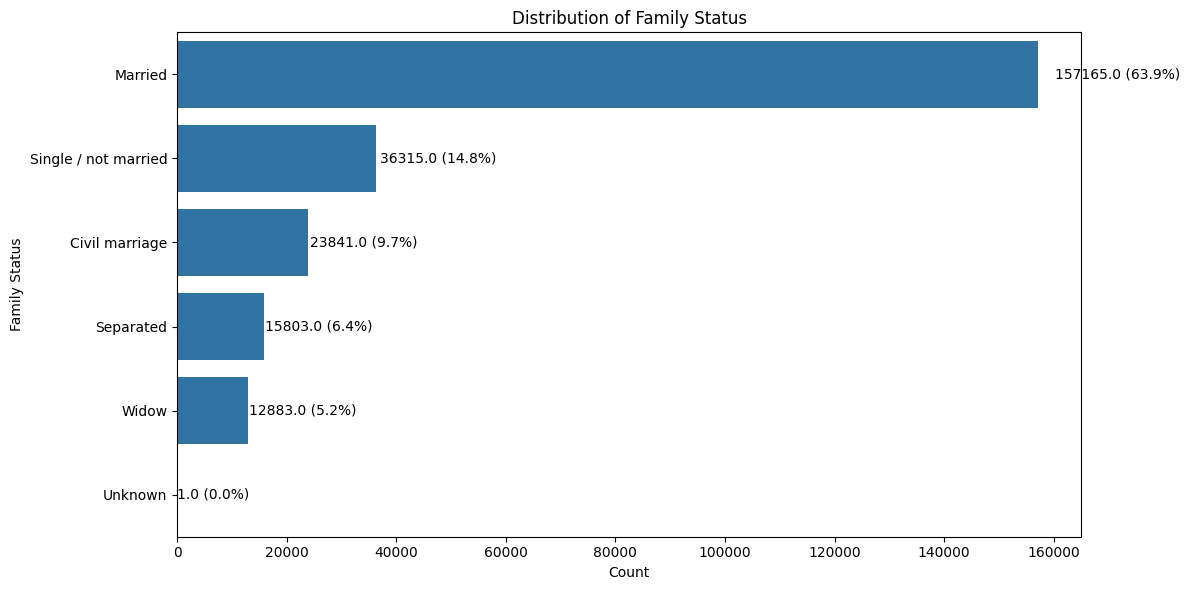

In [13]:
### TODO Complete in this cell: family status
# Count the values in the family status column
family_counts = app_train['NAME_FAMILY_STATUS'].value_counts()
family_percent = app_train['NAME_FAMILY_STATUS'].value_counts(normalize=True) * 100

# Print the counts and percentages
print("Family status distribution:")
print(f"Count:\n{family_counts}")
print(f"\nPercentage:\n{family_percent}")

# Plot the distribution
plt.figure(figsize=(12, 6))
ax = sns.countplot(y='NAME_FAMILY_STATUS', data=app_train, order=family_counts.index)

# Add percentage labels
for i, p in enumerate(ax.patches):
    width = p.get_width()
    plt.text(width + width * 0.02, p.get_y() + p.get_height()/2, 
             f'{width} ({family_percent.iloc[i]:.1f}%)',
             ha='left', va='center')

plt.title('Distribution of Family Status')
plt.xlabel('Count')
plt.ylabel('Family Status')
plt.tight_layout()
plt.show()


1.13. Plot the income type of applicants grouped by the target variable.

*Hint:* Take a look at `NAME_INCOME_TYPE` and `TARGET` columns. You can use `hue` parameter on Seaborn to group samples using another categorical feature.

Income type distribution by target variable:
Counts:
TARGET                     0      1
NAME_INCOME_TYPE                   
Businessman                8      0
Commercial associate   52917   4273
Maternity leave            3      1
Pensioner              41902   2339
State servant          16411    988
Student                   11      0
Unemployed                13      6
Working               114992  12144

Percentages:
TARGET                         0          1
NAME_INCOME_TYPE                           
Businessman           100.000000   0.000000
Commercial associate   92.528414   7.471586
Maternity leave        75.000000  25.000000
Pensioner              94.713049   5.286951
State servant          94.321513   5.678487
Student               100.000000   0.000000
Unemployed             68.421053  31.578947
Working                90.448024   9.551976


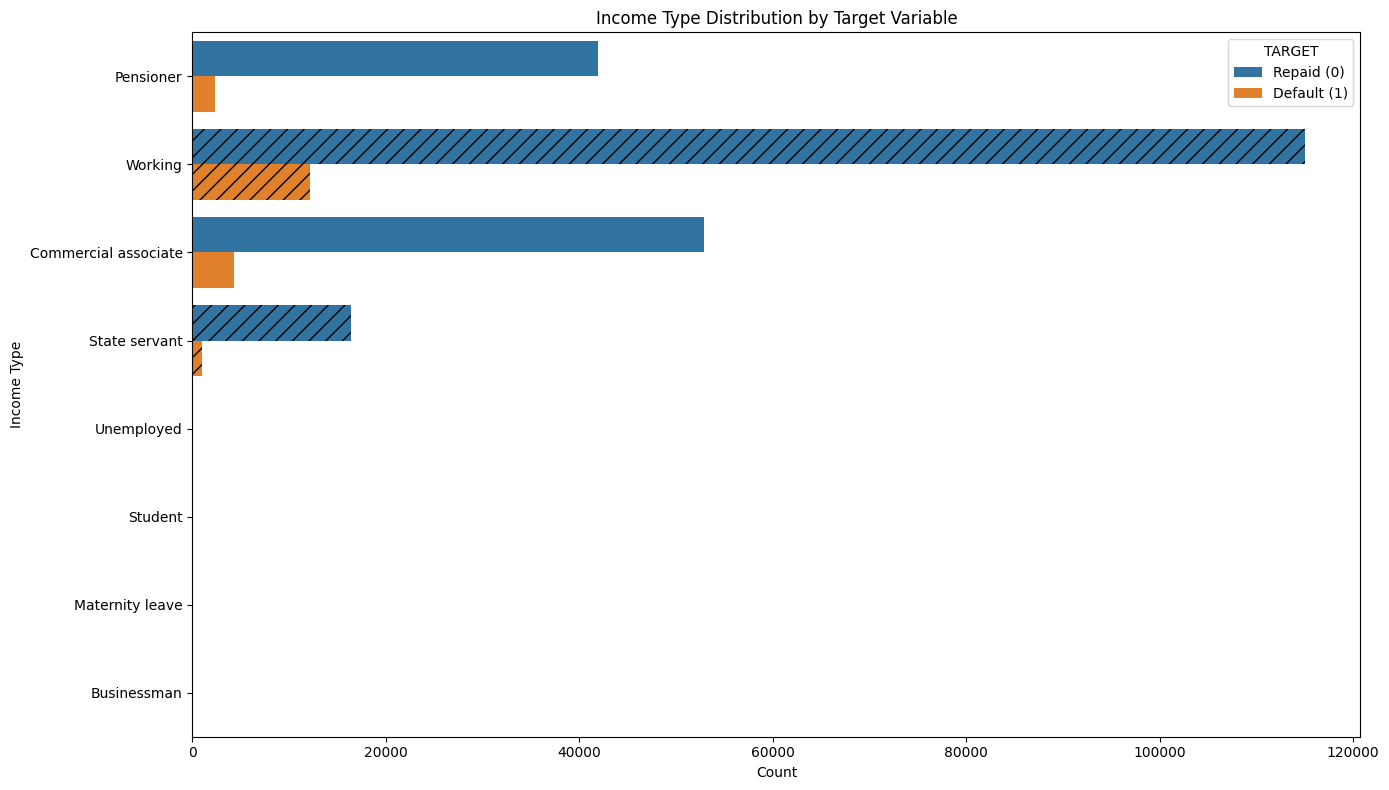

<Figure size 1400x800 with 0 Axes>

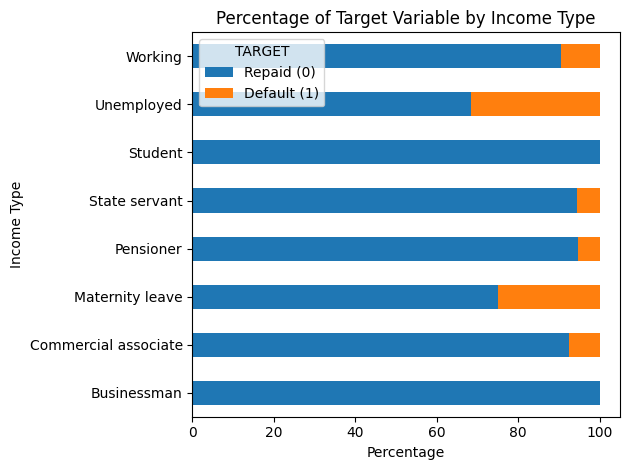

In [14]:
### TODO Complete in this cell: Income type of applicants by target variable
# Count the values in the income type column grouped by target
income_target_counts = pd.crosstab(app_train['NAME_INCOME_TYPE'], app_train['TARGET'])
income_target_percent = pd.crosstab(app_train['NAME_INCOME_TYPE'], app_train['TARGET'], normalize='index') * 100

# Print the counts and percentages
print("Income type distribution by target variable:")
print("Counts:")
print(income_target_counts)
print("\nPercentages:")
print(income_target_percent)

# Plot the distribution
plt.figure(figsize=(14, 8))
ax = sns.countplot(y='NAME_INCOME_TYPE', hue='TARGET', data=app_train)

# Add a legend
plt.legend(title='TARGET', labels=['Repaid (0)', 'Default (1)'])

# Add percentage labels
hatches = ['', '//']
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    width = bar.get_width()
    x = bar.get_x()
    y = bar.get_y()
    
    # Set hatch pattern for better visualization
    bar.set_hatch(hatches[i % 2])
    
plt.title('Income Type Distribution by Target Variable')
plt.xlabel('Count')
plt.ylabel('Income Type')
plt.tight_layout()
plt.show()

# Plot the percentage distribution
plt.figure(figsize=(14, 8))
income_target_percent.plot(kind='barh', stacked=True)
plt.title('Percentage of Target Variable by Income Type')
plt.xlabel('Percentage')
plt.ylabel('Income Type')
plt.legend(title='TARGET', labels=['Repaid (0)', 'Default (1)'])
plt.tight_layout()
plt.show()


## 2. Preprocessing

2.1. The next step will be to separate our train and test datasets columns between Features (the input to the model) and Targets (what the model has to predict with the given features).

- Assign to `X_train` all the columns from `app_train` that should be used as features for training our models.
- Assign to `y_train` the single column from `app_train` that should be used as our target (i.e. what we want to predict).
- Assign to `X_test` all the columns from `app_test` that should be used as features for training our models.
- Assign to `y_test` the single column from `app_test` that should be used as our target (i.e. what we want to predict).

To do that, you will have to complete the function `data_utils.get_feature_target()` in all the parts with a `TODO` mark.


**Don't change anything in this cell, just make it run correctly**

In [15]:
# Now we execute the function above to get the result
X_train, y_train, X_test, y_test = data_utils.get_feature_target(app_train, app_test)


if X_train.shape == (246008, 121):
    print("Success: X_train shape is correct!")
else:
    raise ValueError("X_train dataset shape is incorrect, please review your code")

if isinstance(X_train, pd.DataFrame):
    print("Success: X_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if y_train.shape == (246008,) or y_train.shape == (246008, 1):
    print("Success: y_train shape is correct!")
else:
    raise ValueError("Train labels shape is incorrect, please review your code")

if X_test.shape == (61503, 121):
    print("Success: X_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(X_test, pd.DataFrame):
    print("Success: X_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

if y_test.shape == (61503,) or y_test.shape == (61503, 1):
    print("Success: y_test shape is correct!")
else:
    raise ValueError("Test labels shape is incorrect, please review your code")

Success: X_train shape is correct!
Success: X_train type is correct!
Success: y_train shape is correct!
Success: X_test shape is correct!
Success: X_test type is correct!
Success: y_test shape is correct!


2.2. In order to avoid overfitting while searching for the best model hyperparameters, it's always a good idea to split our training dataset into two new sets called `train` and `validation`. 

While the `train` data will be used to fit the model and adjust its internal weights, the `validation` will be exclusively used to test the model performance on unseen data during training, it's like a testing dataset used during experimentation.

Remember we can't use the `test` dataset to validate the model performance because this one lacks of labels :( So the `validation` data will be the only resource you will have to evaluate the final model performance before doing your submission.

To do that, you will have to complete the function `data_utils.get_train_val_sets()` in all the parts with a `TODO` mark.

This function should perform these activities:
- Use the `sklearn.model_selection.train_test_split` function with `X_train`, `y_train` datasets.
- Assign only 20% of the dataset for testing (see `test_size` parameter in `train_test_split`)
- Assign a seed so we get reproducible output across multiple function calls (see `random_state` parameter in `train_test_split`)
- Shuffle the data (see `shuffle` parameter in `train_test_split`)

For reference, see:
- [Scikit-learn train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
- [Wikipedia: Training, validation, and test data sets](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets)
- [Train Test Validation Split: How To & Best Practices](https://www.v7labs.com/blog/train-validation-test-set)


**Don't change anything in this cell, just make it run correctly**

In [16]:
# Now we execute the function above to get the result
X_train, X_val, y_train, y_val = data_utils.get_train_val_sets(X_train, y_train)


if X_train.shape == (196806, 121):
    print("Success: X_train shape is correct!")
else:
    raise ValueError("X_train dataset shape is incorrect, please review your code")

if isinstance(X_train, pd.DataFrame):
    print("Success: X_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if y_train.shape == (196806,) or y_train.shape == (196806, 1):
    print("Success: y_train shape is correct!")
else:
    raise ValueError("Train labels shape is incorrect, please review your code")

if X_val.shape == (49202, 121):
    print("Success: X_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(X_val, pd.DataFrame):
    print("Success: X_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

if y_val.shape == (49202,) or y_val.shape == (49202, 1):
    print("Success: y_test shape is correct!")
else:
    raise ValueError("Test labels shape is incorrect, please review your code")

Success: X_train shape is correct!
Success: X_train type is correct!
Success: y_train shape is correct!
Success: X_test shape is correct!
Success: X_test type is correct!
Success: y_test shape is correct!


2.3. In this section, you will code a function to make all the data pre-processing for the dataset. What you have to deliver is a function that takes `X_train`, `X_val`, and `X_test` dataframes, processes all features, and returns the transformed data as numpy arrays ready to be used for training.

The function should perform these activities, in this order:

1. Correct outliers/anomalous values in numerical columns (`DAYS_EMPLOYED` column)
2. Encode string categorical features (dytpe `object`):
    - If the feature has 2 categories encode using binary encoding
    - More than 2 categories, use one hot encoding 
3. Impute values for all columns with missing data (use median as imputing value)
4. Feature scaling with Min-Max scaler.

Complete the function `preprocessing.preprocess_data()` following the instructions given above.

In the following cell, we are going to execute the preprocessing function you've just coded. No need to modify this.

**Important Note:** From now on, you must always use `train_data` for training your models and `val_data` only for the final evaluation of the model trained. About `test_data`, it will be used at the end only for submitting your final model predictions and be evaluated on our side with the hidden annotations.


**Don't change anything in this cell, just make it run correctly**

In [17]:
train_data, val_data, test_data = preprocessing.preprocess_data(X_train, X_val, X_test)


if train_data.shape == (196806, 246):
    print("Success: train_data shape is correct!")
else:
    raise ValueError("train_data dataset shape is incorrect, please review your code")

if isinstance(train_data, np.ndarray):
    print("Success: train_data type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if val_data.shape == (49202, 246):
    print("Success: val_data shape is correct!")
else:
    raise ValueError("val_data dataset shape is incorrect, please review your code")

if isinstance(val_data, np.ndarray):
    print("Success: val_data type is correct!")
else:
    raise ValueError("Validation dataset type is incorrect, please review your code")

if test_data.shape == (61503, 246):
    print("Success: test_data shape is correct!")
else:
    raise ValueError("test_data dataset shape is incorrect, please review your code")

if isinstance(test_data, np.ndarray):
    print("Success: test_data type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

Input train data shape:  (196806, 121)
Input val data shape:  (49202, 121)
Input test data shape:  (61503, 121) 

Output train data shape:  (196806, 246)
Output val data shape:  (49202, 246)
Output test data shape:  (61503, 246)
Success: train_data shape is correct!
Success: train_data type is correct!
Success: val_data shape is correct!
Success: val_data type is correct!
Success: test_data shape is correct!
Success: test_data type is correct!


## 3. Training Models

As usual, you will start training simple models and will progressively move to more complex models and pipelines.

**Pro tip:** It is of utmost importance to make an accurate estimation of the time required to train a machine learning model. Because of this, we recommend you to use Python [time](https://docs.python.org/3/library/time.html) library or Jupyter magic function `%%time` on the cell you're training your model to get an estimate of the time it took to fit your data.

### Baseline: LogisticRegression

3.1. Import LogisticRegression from sklearn and train a model using the preprocesed train data from the previous section, and just default parameters. If you receive a warning because the algorithm failed to converge, try increasing the number of iterations or decreasing the C parameter.

Assign the trained model to `log_reg` variable.

**Don't change anything in this cell, just make it run correctly**

In [18]:
%%time

# This is an example code on how to:
#   - Create and fit (train) a logistic regression
#   - Assign to `log_reg` variable
log_reg = None
log_reg = LogisticRegression(C=0.0001)
log_reg.fit(train_data, y_train)

CPU times: total: 6.44 s
Wall time: 1.27 s


,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.0001
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


**Don't change anything in this cell, just make it run correctly**

In [19]:
if isinstance(log_reg, LogisticRegression):
    print("Success: Logistic regression model type is correct!")
else:
    raise ValueError(
        "Logistic regression model type is incorrect, please review your code"
    )

check_is_fitted(log_reg)

Success: Logistic regression model type is correct!


3.2. Use the trained model to predict probabilities for `train_data` and `val_data`.

**Important note:** When using the function `predict_proba()` for getting model probabilities you will get, for each sample, a tuple indicating the probability for class 0 and for class 1 respectively. For computing the AUC ROC score we only need the probability that the debt is not repaid (equivalent to class 1). As an example, the result from running `predict_proba()` on validation dataset will have a shape of `(49202, 2)` but, we only need the second column from that matrix, which corresponds to the class 1.


**Don't change anything in this cell, just make it run correctly**

In [20]:
# Example code to show you how to use the Logistic Regression model
# to predict probabilities for each class and then, use the probabilities for the
# class 1 only.

# Train data predictions (class 1)
log_reg_train = log_reg.predict_proba(train_data)[:, 1]

# Validation data predictions (class 1)
log_reg_val = log_reg.predict_proba(val_data)[:, 1]

3.3. Get AUC ROC score on train and validation datasets. See [scikit-learn AUC ROC function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) for a working implementation.

Assign the AUC ROC score to `lr_roc_auc` variable.


**Don't change anything in this cell, just make it run correctly**

In [21]:
# Example code to show you how to get the ROC AUC Score on train and val datasets

# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=log_reg_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_val, y_score=log_reg_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 0.6795
Validation ROC AUC Score: 0.6769


At this point, the model should produce a result of around 0.67.

**Question:** Comparing train and validation results, do you observe underfitting, overfitting, or none of those two?

**Don't change anything in this cell, just make it run correctly**

In [22]:
if isinstance(roc_auc_val, float):
    print("Success: AUC ROC score type is correct!")
else:
    raise ValueError("AUC ROC score type is incorrect, please review your code")

if roc_auc_val >= 0.6:
    print("Success: AUC ROC score is correct!")
else:
    raise ValueError("AUC ROC score is incorrect, please review your code")

Success: AUC ROC score type is correct!
Success: AUC ROC score is correct!


### Training a Random Forest Classifier 

You're gonna start working in more complex models: ensambles, particularly, you're going to use the Random Forest Classifier from Scikit Learn. 

3.4. Train a RandomForestClassifier, print the time taken by the fit function. Just use default hyperparameters, except for `n_jobs`, which should be set to "-1" to allow the library to use all CPU cores to speed up training time.

In [23]:
%%time

# TODO Write your code here for training a Random Forest model.
#   - Please use sklearn.ensemble.RandomForestClassifier() class.
#   - Assign the model to the variable `rf`.
#   - Remember to fit the model only on `train_data`.
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
rf.fit(train_data, y_train)


CPU times: total: 3min 37s
Wall time: 24.9 s


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


**Don't change anything in this cell, just make it run correctly**

In [24]:
if isinstance(rf, RandomForestClassifier):
    print("Success: RandomForestClassifier model type is correct!")
else:
    raise ValueError(
        "RandomForestClassifier model type is incorrect, please review your code"
    )

check_is_fitted(rf)

Success: RandomForestClassifier model type is correct!


3.5. Use the classifier to predict probabilities for `train_data` and `val_data`.

In [25]:
# TODO Use the Random Forest model to predict probabilities for each class and then,
# use the probabilities for the class 1 only.

# Train data predictions (class 1)
rf_pred_train = rf.predict_proba(train_data)[:, 1]

# Validation data predictions (class 1)
rf_pred_val = rf.predict_proba(val_data)[:, 1]

3.6. Get AUC ROC score on train and validation datasets.


In [26]:
# TODO Get the ROC AUC Score on train_data and val_data datasets.
# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=rf_pred_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_val, y_score=rf_pred_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 1.0000
Validation ROC AUC Score: 0.7078


At this point, the model should produce a result around 0.7.

**Question:** Comparing train and validation results, do you observe underfitting, overfitting, or none of those two?

### Randomized Search with Cross Validation

So far, we've only created models using the default hyperparameters of each algorithm. This is usually something that we would only do for baseline models, hyperparameter tuning is a very important part of the modeling process and is often the difference between having an acceptable model or not.

But, there are usually lots of hyperparameters to tune and a finite amount of time to do it, you have to consider the time and resources it takes to find an optimal combination of them. In the previous section you trained a random forest classifier and saw how much it took to train it once in your PC. If you want to do hyperparameter optimization you now have to consider that you will have to train the algorithm N number of times, with N being the cartesian product of all parameters. 

Furthermore, you can't validate the performance of your trained models on the test set, as this data should only be used to validate the final model. So we have to implement a validation strategy, K-Fold Cross Validation being the most common. But this also adds time complexity to our training, because we will have to train each combinations of hyperparameters M number of times, X being the number of folds in which we divided our dataset, so the total number of training iterations will be NxM... this resulting number can grow VERY quickly.

Fortunately there are strategies to mitigate this, here you're going to select a small number of hyperparameters to test a RandomForestClassifier, and use a Randomized Search algorithm with K-Fold Cross Validation to avoid doing a full search across the grid. 

Remember: take in consideration how much time it took to train a single classifier, and define the number of cross validations folds and iterations of the search accordingly. 
A recommendation: run the training process, go make yourself a cup of coffee, sit somewhere comfortably and forget about it for a while.


3.7. Use `sklearn.model_selection.RandomizedSearchCV()` to find the best combination of hyperparameters for a Random Forest model. 

The validation metric used to evaluate the models should be "roc_auc" (i.e. `scoring="roc_auc"`).

In [27]:
%%time

# TODO Write your code here for training a Random Forest model using Random Search
# of hyper-parameters.
#   - Please use sklearn.model_selection.RandomizedSearchCV() and
#     sklearn.ensemble.RandomForestClassifier() classes.
#   - Assign the RandomizedSearchCV model to the variable `rf_random`.
#   - Remember to fit the model only on `train_data`.

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create the RandomForestClassifier
rf_base = RandomForestClassifier(n_jobs=-1, random_state=42)

# Create the RandomizedSearchCV object
rf_random = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings sampled
    cv=3,       # Number of cross-validation folds
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Fit the RandomizedSearchCV
rf_random.fit(train_data, y_train)

# Print the best parameters and best score
print(f"Best parameters: {rf_random.best_params_}")
print(f"Best ROC AUC score: {rf_random.best_score_:.4f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 20, 'bootstrap': False}
Best ROC AUC score: 0.7359
CPU times: total: 11min 43s
Wall time: 14min 22s


3.8. Use the classifier to predict probabilities on the train and test data.


In [28]:
# TODO Use the RandomizedSearchCV model to predict probabilities for each class and
# then, use the probabilities for the class 1 only.

# Train data predictions (class 1)
rf_tuned_pred_train = rf_random.predict_proba(train_data)[:, 1]

# Validation data predictions (class 1)
rf_tuned_pred_val = rf_random.predict_proba(val_data)[:, 1]

3.9. Get AUC ROC score on train and validation datasets.

In [29]:
# TODO Get the ROC AUC Score on train_data and val_data datasets.
# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=rf_tuned_pred_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_val, y_score=rf_tuned_pred_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 0.9879
Validation ROC AUC Score: 0.7379


At this point, the model should produce a result around 0.7 or higher.

**Question:** Comparing train and validation results, do you observe underfitting, overfitting, or none of those two?

## 4. Predict unlabeled data

Now it's time to finally use the `test_data` samples. Because we don't have the labels we can't see how the model performs on this dataset (╯°□°)╯︵ ┻━┻

But... don't worry, we will internally evaluate your model and give feedback on the results!

In the cells below:
- Take your best model
- Take `test_data` (i.e. the dataset after doing the preprocessing and feature engineering part)
- Run the data through your model and save the predictions on the `TARGET` column in the `app_test` DataFrame (yeah that we've loaded at the very beginning of this notebook).
    - `TARGET` column values must be the probabilities for class 1. So remember to use the `predict_proba()` function from your model as we did in the previous sections.
- Save the modified version of the DataFrame with the same name it has before (`dataset/application_test_aai.csv`) and don't forget to submit it alongside the rest of this sprint project code
- And finally, don't get confused, you shouldn't submit `dataset/application_train_aai.csv`. So please don't upload your solution with this heavy dataset inside.

Let's say your best model is called `best_credit_model_ever`, then your code should be exactly this:

```python
    test_preds = best_credit_model_ever.predict_proba(test_data)[:, 1]
    app_test["TARGET"] = test_preds
    app_test.to_csv(config.DATASET_TEST, index=False)
```


In [30]:
%%time

# TODO Use your best model and call the predict_proba() on test_data then,
# use the probabilities for the class 1 only.
# Then, put the predictions in app_test["TARGET"] and save the DataFrame as a csv
# with the same name it originally has ("application_test_aai.csv").

# Use the best model (RandomizedSearchCV model in this case)
test_preds = rf_random.predict_proba(test_data)[:, 1]

# Add predictions to the app_test DataFrame
app_test["TARGET"] = test_preds

# Save the DataFrame as CSV
app_test.to_csv(config.DATASET_TEST, index=False)

print(f"Predictions saved to {config.DATASET_TEST}")
print(f"Shape of predictions: {test_preds.shape}")
print(f"Sample of predictions: {test_preds[:5]}")


Predictions saved to c:\Users\joel_\OneDrive\Escritorio\ML_Learning\fintech_pipeline_ml\assignment\dataset\application_test_aai.csv
Shape of predictions: (61503,)
Sample of predictions: [0.14900408 0.20257165 0.051867   0.17658035 0.04012083]
CPU times: total: 17.5 s
Wall time: 7.37 s


## 5. Optional exercises

### Optional: Training a LightGBM model 

5.1. Gradient Boosting Machine is one of the most used machine learning algorithms for tabular data. Lots of competitions have been won using models from libraries like XGBoost or LightGBM. You can try using [LightGBM](https://lightgbm.readthedocs.io/en/latest/) to train a new model an see how it performs compared to the other classifiers you trained. 

Installing LightGBM...
LightGBM installed successfully
Training LightGBM model...
Starting hyperparameter tuning for LightGBM...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best LightGBM parameters: {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0.5, 'num_leaves': 31, 'n_estimators': 300, 'min_child_samples': 50, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best LightGBM ROC AUC score: 0.7561


c:\Users\joel_\OneDrive\Escritorio\ML_Learning\fintech_pipeline_ml\assignment\myEnv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\joel_\OneDrive\Escritorio\ML_Learning\fintech_pipeline_ml\assignment\myEnv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



LightGBM Results:
Train ROC AUC Score: 0.7794
Validation ROC AUC Score: 0.7552

Model Comparison:
Logistic Regression - Val AUC: 0.6769
Random Forest (tuned) - Val AUC: 0.7379
LightGBM (tuned) - Val AUC: 0.7552

Top 20 Most Important Features (by LightGBM):
 1. Feature 33: 151.00
 2. Feature 31: 148.00
 3. Feature 6: 108.00
 4. Feature 10: 101.00
 5. Feature 32: 98.00
 6. Feature 8: 86.00
 7. Feature 7: 76.00
 8. Feature 13: 68.00
 9. Feature 11: 65.00
10. Feature 82: 55.00
11. Feature 12: 53.00
12. Feature 5: 42.00
13. Feature 9: 42.00
14. Feature 0: 30.00
15. Feature 134: 22.00
16. Feature 107: 22.00
17. Feature 110: 21.00
18. Feature 24: 21.00
19. Feature 2: 20.00
20. Feature 14: 20.00


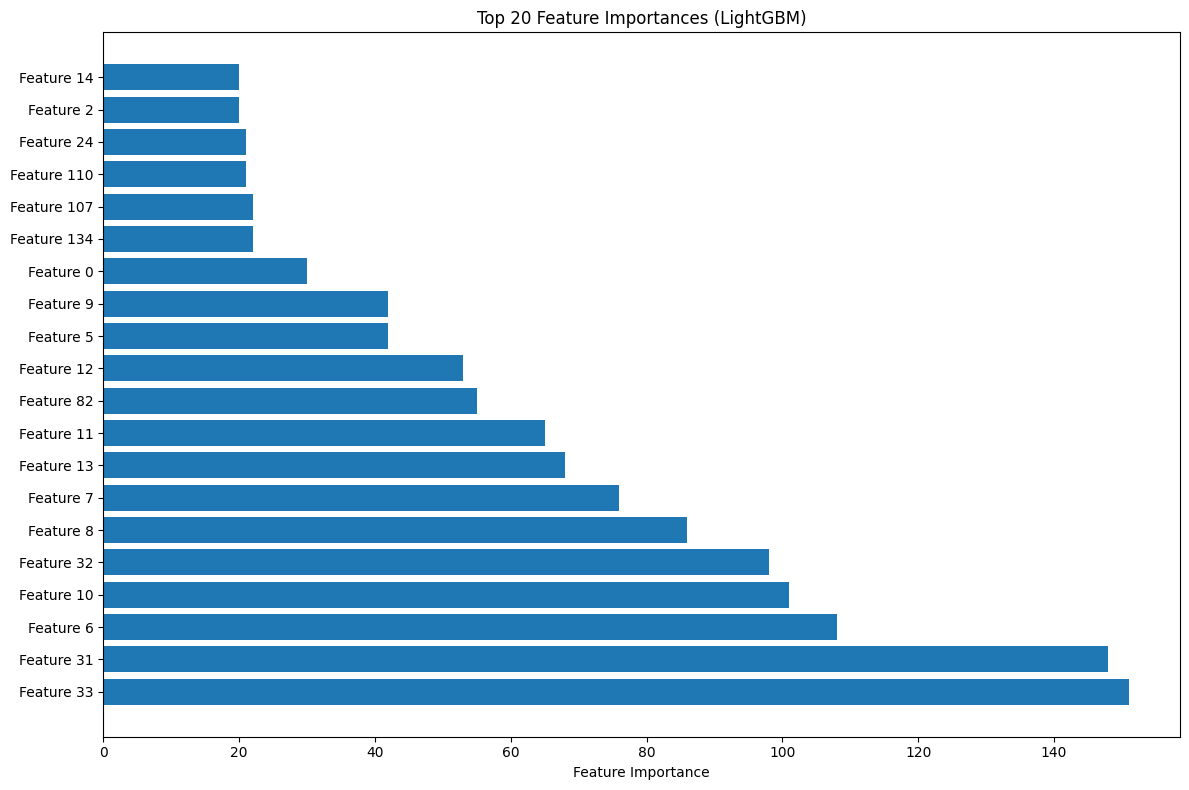

c:\Users\joel_\OneDrive\Escritorio\ML_Learning\fintech_pipeline_ml\assignment\myEnv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Test Predictions Comparison:
LightGBM - Mean: 0.0806, Std: 0.0781
LightGBM - Min: 0.0014, Max: 0.7361
LightGBM predictions saved to dataset/application_test_aai_lightgbm.csv


In [34]:
### Complete in this cell: train a LightGBM model

# First, let's install lightgbm if not already installed
try:
    import lightgbm as lgb
    print("LightGBM is already installed")
except ImportError:
    print("Installing LightGBM...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "lightgbm"])
    import lightgbm as lgb
    print("LightGBM installed successfully")

from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

print("Training LightGBM model...")

# Define parameter grid for LightGBM hyperparameter tuning
lgb_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10, -1],  # -1 means no limit
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [31, 50, 100, 200],
    'min_child_samples': [20, 30, 50, 100],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

# Create LightGBM classifier
lgb_base = LGBMClassifier(
    objective='binary',
    metric='auc',
    boosting_type='gbdt',
    random_state=42,
    n_jobs=-1,
    verbose=-1  # Suppress warnings
)

# Create RandomizedSearchCV for hyperparameter tuning
lgb_random = RandomizedSearchCV(
    estimator=lgb_base,
    param_distributions=lgb_param_grid,
    n_iter=20,  # Number of parameter settings sampled
    cv=3,       # Number of cross-validation folds
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Train the model with hyperparameter tuning
print("Starting hyperparameter tuning for LightGBM...")
lgb_random.fit(train_data, y_train)

print(f"Best LightGBM parameters: {lgb_random.best_params_}")
print(f"Best LightGBM ROC AUC score: {lgb_random.best_score_:.4f}")

# Make predictions
lgb_pred_train = lgb_random.predict_proba(train_data)[:, 1]
lgb_pred_val = lgb_random.predict_proba(val_data)[:, 1]

# Calculate ROC AUC scores
lgb_roc_auc_train = roc_auc_score(y_true=y_train, y_score=lgb_pred_train)
lgb_roc_auc_val = roc_auc_score(y_true=y_val, y_score=lgb_pred_val)

print(f"\nLightGBM Results:")
print(f"Train ROC AUC Score: {lgb_roc_auc_train:.4f}")
print(f"Validation ROC AUC Score: {lgb_roc_auc_val:.4f}")

# Compare with previous models
print(f"\nModel Comparison:")
print(f"Logistic Regression - Val AUC: 0.6769")  # From previous results
print(f"Random Forest (tuned) - Val AUC: 0.7379")  # From previous results  
print(f"LightGBM (tuned) - Val AUC: {lgb_roc_auc_val:.4f}")

# Feature importance analysis
feature_importance = lgb_random.best_estimator_.feature_importances_
top_features_idx = np.argsort(feature_importance)[-20:]  # Top 20 features

print(f"\nTop 20 Most Important Features (by LightGBM):")
for i, idx in enumerate(reversed(top_features_idx)):
    print(f"{i+1:2d}. Feature {idx}: {feature_importance[idx]:.2f}")

# Plot feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.barh(range(20), feature_importance[top_features_idx])
plt.yticks(range(20), [f'Feature {idx}' for idx in top_features_idx])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances (LightGBM)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Optional: Make predictions on test data and compare with Random Forest
lgb_test_preds = lgb_random.predict_proba(test_data)[:, 1]

print(f"\nTest Predictions Comparison:")
print(f"LightGBM - Mean: {lgb_test_preds.mean():.4f}, Std: {lgb_test_preds.std():.4f}")
print(f"LightGBM - Min: {lgb_test_preds.min():.4f}, Max: {lgb_test_preds.max():.4f}")

# Save LightGBM predictions as an alternative (optional)
# You can uncomment these lines if you want to save LightGBM predictions
app_test_lgb = app_test.copy()
app_test_lgb["TARGET"] = lgb_test_preds
app_test_lgb.to_csv("dataset/application_test_aai_lightgbm.csv", index=False)
print("LightGBM predictions saved to dataset/application_test_aai_lightgbm.csv")

### Optional: Using Scikit Learn Pipelines 

5.2. So far you've created special functions or blocks or code to chain operations on data and then train the models. But, reproducibility is important, and you don't want to have to remember the correct steps to follow each time you have new data to train your models. There are a lots of tools out there that can help you with that, here you can use a [Sklearn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to process your data.

In [35]:
### Complete in this cell: use a sklearn Pipeline to automate the cleaning, standardizing and training

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

print("Creating comprehensive sklearn Pipeline...")

# First, let's identify column types from the original data (before preprocessing)
# We'll use X_train (the original features) for this
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Remove TARGET if it exists in numerical_cols (it shouldn't, but just in case)
if 'TARGET' in numerical_cols:
    numerical_cols.remove('TARGET')

print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols[:5]}...")
print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols[:5]}...")

# Define preprocessing steps for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define preprocessing steps for categorical features
# We'll use a custom approach to handle binary vs multi-class encoding
def create_categorical_transformer():
    """Create a transformer that handles both binary and multi-class categorical variables"""
    
    # For simplicity, we'll use OneHotEncoder for all categorical variables
    # In a more sophisticated approach, we could separate binary from multi-class
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    return categorical_transformer

categorical_transformer = create_categorical_transformer()

# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop'  # Drop any columns not specified
)

# Create the complete pipeline with preprocessing + model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ))
])

print("\\nTraining pipeline on original data...")
print("This will handle all preprocessing steps automatically!")

# Train the pipeline on the original data (X_train, y_train)
# The pipeline will automatically handle all preprocessing
pipeline.fit(X_train, y_train)

print("\\nPipeline training completed!")

# Make predictions
train_pred_pipeline = pipeline.predict_proba(X_train)[:, 1]
val_pred_pipeline = pipeline.predict_proba(X_val)[:, 1]

# Calculate ROC AUC scores
from sklearn.metrics import roc_auc_score

train_auc_pipeline = roc_auc_score(y_train, train_pred_pipeline)
val_auc_pipeline = roc_auc_score(y_val, val_pred_pipeline)

print(f"\\nPipeline Results:")
print(f"Train ROC AUC: {train_auc_pipeline:.4f}")
print(f"Validation ROC AUC: {val_auc_pipeline:.4f}")

# Cross-validation to get a more robust estimate
print("\\nPerforming 3-fold cross-validation...")
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1)
print(f"Cross-validation ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

print("\\n" + "="*60)
print("PIPELINE BENEFITS:")
print("="*60)
print("✅ Automatic preprocessing: No need to manually preprocess data")
print("✅ Reproducible: Same steps applied consistently")
print("✅ Easy to deploy: Single object handles everything")
print("✅ Prevents data leakage: Preprocessing fit only on training data")
print("✅ Easy to modify: Change any step without affecting others")
print("="*60)

# Advanced Pipeline with hyperparameter tuning
print("\\n" + "="*60)
print("ADVANCED PIPELINE WITH HYPERPARAMETER TUNING:")
print("="*60)

from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for the pipeline
pipeline_param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'preprocessor__num__imputer__strategy': ['median', 'mean']
}

# Create advanced pipeline with hyperparameter tuning
advanced_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Create RandomizedSearchCV for the pipeline
pipeline_search = RandomizedSearchCV(
    estimator=advanced_pipeline,
    param_distributions=pipeline_param_grid,
    n_iter=5,  # Limited for demo purposes
    cv=3,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

print("Training advanced pipeline with hyperparameter tuning...")
pipeline_search.fit(X_train, y_train)

print(f"\\nBest pipeline parameters: {pipeline_search.best_params_}")
print(f"Best pipeline ROC AUC score: {pipeline_search.best_score_:.4f}")

# Make predictions with the best pipeline
best_pipeline_train_pred = pipeline_search.predict_proba(X_train)[:, 1]
best_pipeline_val_pred = pipeline_search.predict_proba(X_val)[:, 1]

best_train_auc = roc_auc_score(y_train, best_pipeline_train_pred)
best_val_auc = roc_auc_score(y_val, best_pipeline_val_pred)

print(f"\\nBest Pipeline Results:")
print(f"Train ROC AUC: {best_train_auc:.4f}")
print(f"Validation ROC AUC: {best_val_auc:.4f}")

print("\\n" + "="*60)
print("PIPELINE SUMMARY:")
print("="*60)
print("📊 Basic Pipeline - Validation AUC: {:.4f}".format(val_auc_pipeline))
print("🚀 Advanced Pipeline - Validation AUC: {:.4f}".format(best_val_auc))
print("📈 LightGBM (from 5.1) - Validation AUC: 0.7552")
print("🌲 Random Forest (tuned) - Validation AUC: 0.7379")
print("="*60)

Creating comprehensive sklearn Pipeline...
Categorical columns (16): ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE']...
Numerical columns (105): ['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY']...
\nTraining pipeline on original data...
This will handle all preprocessing steps automatically!
\nPipeline training completed!
\nPipeline Results:
Train ROC AUC: 1.0000
Validation ROC AUC: 0.7030
\nPerforming 3-fold cross-validation...
Cross-validation ROC AUC: 0.7048 (+/- 0.0058)
\n============================================================
PIPELINE BENEFITS:
✅ Automatic preprocessing: No need to manually preprocess data
✅ Reproducible: Same steps applied consistently
✅ Easy to deploy: Single object handles everything
✅ Prevents data leakage: Preprocessing fit only on training data
✅ Easy to modify: Change any step without affecting others
\n============================================================
ADVANCED PIPELI